In [378]:
library(caret)

In [379]:
library(GDINA);
library(bnlearn);
library(Rgraphviz);

In [380]:
# Item Response dat of sample sizes I=500 or 2000 were drawn from 
# discretized multivariate normal distribution with 0 mean and sigma sd.
# sigma has unit variance and correlation of rho = 0.3 or 0.6
# J = 20 or 40 
# item parameters = uniform (0,0.3)
sigma <- matrix(rep(0.3, times=25), ncol=5)
diag(sigma) <- 1
QMat <- read.csv("q.csv")
guess <- rep(0.3, nrow(QMat));

Generating Simulated Data

In [381]:
simdat <- CDM::sim.din(N=1000,
                        QMat, guess = guess, slip = guess,
                        Sigma=sigma, rule="DINA")

In [382]:
obs<-simdat$dat
colnames(obs) <- c("x1", "x2", "x3","x4", "x5",
                    "x6", "x7", "x8", "x9", "x10",
                    "x11", "x12", "x13", "x14", "x15",
                    "x16", "x17", "x18", "x19", "x20")
obsdf<- as.data.frame(lapply(as.data.frame(obs),factor))

In [383]:
## This block needs some code cleaning
fulldat <- cbind(simdat$dat, simdat$alpha)
colnames(fulldat)<- c("x1", "x2", "x3","x4", "x5",
                    "x6", "x7", "x8", "x9", "x10",
                    "x11", "x12", "x13", "x14", "x15",
                    "x16", "x17", "x18", "x19", "x20",
                    "a1", "a2","a3","a4","a5")
#fulldat[, colnames(fulldat)] = lapply(fulldat[, colnames(fulldat)], as.factor)
fdf <- as.data.frame(fulldat)
factoreddata <- data.frame(lapply(fdf, factor))

In [384]:
rownames(QMat) <- colnames(obsdf)
colnames(QMat) <- c("a1", "a2", "a3", "a4", "a5")
items <- rownames(QMat)

In [385]:
skills <- colnames(QMat)

Creating a list of $\frac{J \times (J-1)}{2}$ item-pairs

In [386]:
itemnames <- rownames(QMat)
itemcomb <- t(combn(itemnames,2))

Function to test the conditional independence between item pairs 

In [387]:
check_ind <- function(test_type){
    cf = list()
    # Testing when link is present
    # Items that share an attribute should be correlated
    for (i in 1:ncol(QMat)){
        corr_items <-items[as.logical(QMat[,i])]
        test_set <- as.data.frame(t(combn(corr_items,2)))

        for (i in 1:nrow(test_set)){
        testres <- ci.test(test_set$V1[i], test_set$V2[i], data =obsdf, test = test_type)
            if (testres$p.val <= 0.05){
            # The null hypothesis that the given set of nodes are independent
            # When we have p <0.05, we reject the null
                dep <- "1"
            }
            else {
                dep <- "0"
            }
        cf <- rbind(cf,c("1",dep))
        }
    }
    # Testing when link is absent 
    # Theory says obs are independent after we condition on the common attribute  
    for (i in 1:nrow(itemcomb)){
        indc <- as.logical(QMat[itemcomb[i,][1],] * QMat[itemcomb[i,][2],])
        tmp <- ci.test(itemcomb[i,][1], itemcomb[i,][2],skills[indc], 
                    test = test_type, data=factoreddata)
        if(tmp$p.val <= 0.05){
            dep <- "1" 
        }
        else {
        dep <-"0"
        }
        cf <- rbind(cf,c("0",dep))
    }
    return(cf)
}

In [367]:
#big_cf = list()
#for (i in 1:100){
#
#    simdat <- CDM::sim.din(N=200,
#    QMat, guess = guess,    slip = guess,
#    Sigma=sigma, rule="DINA")

#    obs<-simdat$dat
#    colnames(obs) <- c("x1", "x2", "x3","x4", "x5",
#                    "x6", "x7", "x8", "x9", "x10",
#                    "x11", "x12", "x13", "x14", "x15",
#                    "x16", "x17", "x18", "x19", "x20")
#    obsdf<- as.data.frame(lapply(as.data.frame(obs),factor))

#    fulldat <- cbind(simdat$dat, simdat$alpha)
#    colnames(fulldat)<- c("x1", "x2", "x3","x4", "x5",
#                    "x6", "x7", "x8", "x9", "x10",
#                    "x11", "x12", "x13", "x14", "x15",
#                    "x16", "x17", "x18", "x19", "x20",
#                    "a1", "a2","a3","a4","a5")
#    #fulldat[, colnames(fulldat)] = lapply(fulldat[, colnames(fulldat)], as.factor)
#    fdf <- as.data.frame(fulldat)
#    factoreddata <- data.frame(lapply(fdf, factor))
#    factoreddata

#    rownames(QMat) <- colnames(obsdf)
#    colnames(QMat) <- c("a1", "a2", "a3", "a4", "a5")
#    items <- rownames(QMat)
#    skills <- colnames(QMat)
#    itemnames <- rownames(QMat)
#    itemcomb <- t(combn(itemnames,2))
#    res = check_ind("mi")
#    big_cf = rbind(big_cf,res)
#}

In [388]:
cf = check_ind("x2")

In [389]:
trues<- as.data.frame(factor(cf[,1], levels = c('1','0')))
preds<- as.data.frame(factor(cf[,2], levels = c('1','0')))
cdf <- data.frame(trues,preds)
colnames(cdf) <- c("true_val", "pred_val")

In [409]:
cf <- confusionMatrix(data=cdf$pred_val, reference = cdf$true_val)

In [413]:
attributes(cf$byClass)

$names
 [1] "Sensitivity"          "Specificity"          "Pos Pred Value"      
 [4] "Neg Pred Value"       "Precision"            "Recall"              
 [7] "F1"                   "Prevalence"           "Detection Rate"      
[10] "Detection Prevalence" "Balanced Accuracy"

In [391]:
library(pROC)

In [402]:
roc_score <-roc(as.numeric(cdf$true_val), as.numeric(cdf$pred_val), thresholds = c(0.1,0.001,1))

Setting levels: control = 1, case = 2

Setting direction: controls < cases



In [404]:
attributes(roc_score)

$names
 [1] "percent"            "sensitivities"      "specificities"     
 [4] "thresholds"         "direction"          "cases"             
 [7] "controls"           "fun.sesp"           "auc"               
[10] "call"               "original.predictor" "original.response" 
[13] "predictor"          "response"           "levels"            

$class
[1] "roc"

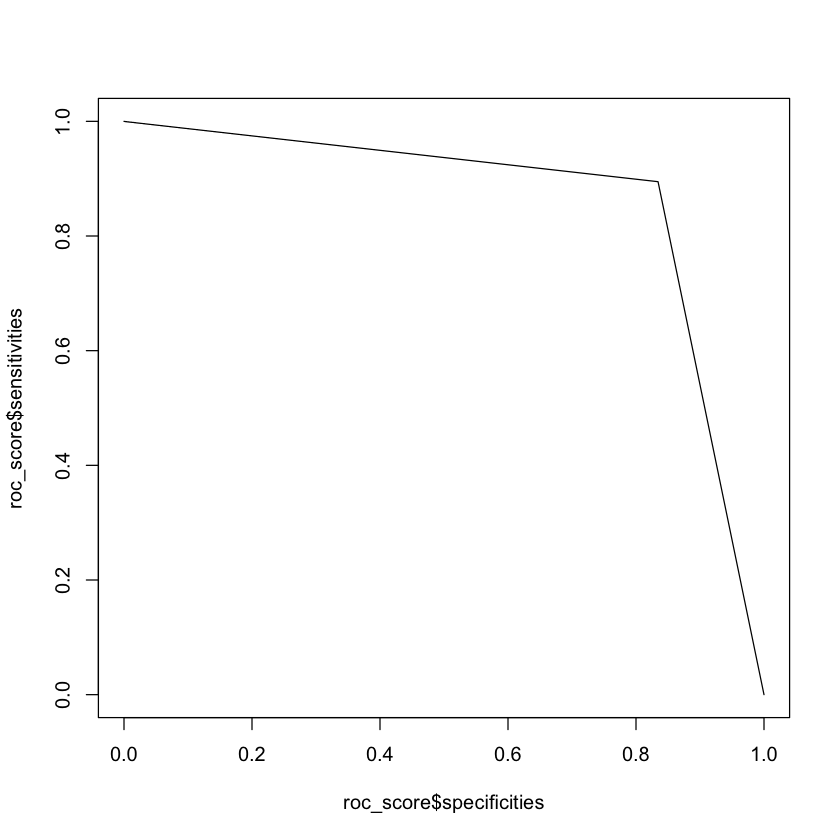

In [408]:
plot(roc_score$specificities, roc_score$sensitivities,type="l")

In [399]:
ci.thresholds(roc_score, thresholds = c(0.1,.0.01,1))

ERROR: Error in parse(text = x, srcfile = src): <text>:1:47: unexpected numeric constant
1: ci.thresholds(roc_score, thresholds = c(0.1,.0.01
                                                  ^


In [377]:
 mean(as.numeric(roc_score), na.rm=TRUE)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'mean': 'list' object cannot be coerced to type 'double'


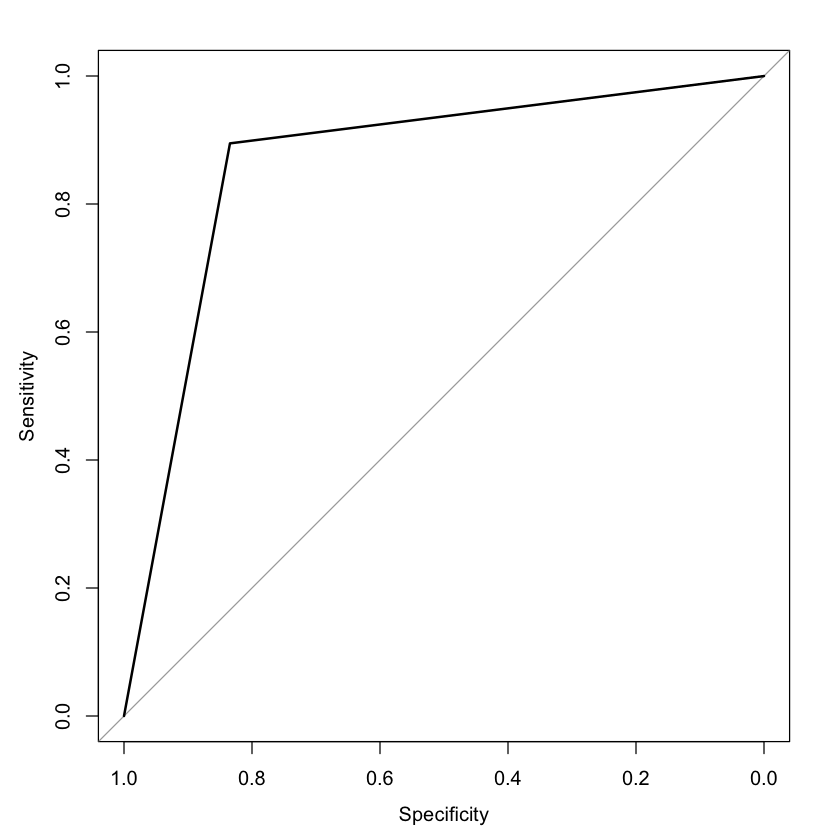

In [396]:
plot(roc_score)

In [374]:
auc(roc_score)

Area under the curve: 0.7877